In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [2]:
# Blocks for models

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        # First Conv -> BN -> ReLu
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels) # normalization
        self.relu = nn.ReLU(inplace=True) # learn non-linearity

        # Second Conv -> BN (add padding=1 to preserve spatial size)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        identity = x # Save input for the residual stuff

        out = self.conv1(x) 
        out = self.bn1(out)
        out = self.relu(out) 
        out = self.conv2(out)      
        out = self.bn2(out)        
        out = out + identity # Add skip connection
        out = self.relu(out) 

        return out


class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # split output channels evenly across branches
        # each branch gets 0.25 of the channelse becasue there is 4 branches
        c = out_channels // 4 

        # 1×1 conv branch
        self.branch1 = nn.Conv2d(in_channels, c, kernel_size=1)

        # 3×3 conv branch
        self.branch3 = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)

        # 5×5 convn branch
        self.branch5 = nn.Conv2d(in_channels, c, kernel_size=5, padding=2)

        # Pooling branch (keeps spatial size)
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, c, kernel_size=1)
        )

    def forward(self, x):
        # apply all branches in parallel
        # same image goes into all branches
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.branch_pool(x)

        # Concatenate along the channel dimension
        return torch.cat([b1, b3, b5, bp], dim=1)

class FireModule(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand_channels):
        super().__init__()

        # squeeze layer: 1×1 convolution (reduces channels)
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

        # expand in two paths 1×1 and 3×3 convolutions
        self.expand1x1 = nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1)
        self.expand3x3 = nn.Conv2d(
            squeeze_channels, expand_channels, kernel_size=3, padding=1
        )

    def forward(self, x):
        x = self.relu(self.squeeze(x)) # Squeeze step

        e1 = self.relu(self.expand1x1(x)) # Expand with 1×1
        e3 = self.relu(self.expand3x3(x)) # Expand with 3×3

        return torch.cat([e1, e3], dim=1) # Concatenate channels

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=2)

classes = trainset.classes

/home/coder/ikt469/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [4]:
# Experts

num_channels = 32 
# All models will use 2 conv-like blocks with num_channels channels, followed by global pooling and a 10-class linear layer.
# Baseline: Plain CNN
class PlainCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, num_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(num_channels, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Small ResNet-like model
class SmallResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, num_channels, 3, padding=1)
        self.res1 = ResidualBlock(num_channels)
        self.res2 = ResidualBlock(num_channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(num_channels, 10)
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.res1(x)
        x = self.res2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Small Inception-like model
class SmallInceptionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, num_channels, 3, padding=1)
        self.incept1 = InceptionBlock(num_channels, num_channels)
        self.incept2 = InceptionBlock(num_channels, num_channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(num_channels, 10)
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.incept1(x)
        x = self.incept2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Small SqueezeNet-like model
class SmallSqueezeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, num_channels, 3, padding=1)
        self.fire1 = FireModule(num_channels, 16, 16)
        self.fire2 = FireModule(num_channels, 16, 16)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(num_channels, 10)
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.fire1(x)
        x = self.fire2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
class SuperNet(nn.Module):
    def __init__(self):
        super().__init__()
        channels = 32
        self.stem = nn.Conv2d(3, channels, 3, padding=1)
        self.res1 = ResidualBlock(channels)
        self.incept = InceptionBlock(channels, channels)
        self.fire = FireModule(channels, 16, 16)
        self.bn = nn.BatchNorm2d(channels)
        self.res2 = ResidualBlock(channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(channels, 10)

    def forward(self, x):
        x = F.relu(self.stem(x))
        res = self.res1(x)
        out = self.incept(res)
        out = self.fire(out)
        out = self.bn(out)
        out = self.res2(out)
        out = out + res  # skip connection over the main path
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        return self.fc(out)

In [ ]:
# Training and evaluation function for all models

def train_and_evaluate(model_class, name, device, trainloader, testloader, epochs=10):
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_acc_hist, val_acc_hist = [], []
    train_loss_hist, val_loss_hist = [], []
    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_acc = correct / total
        train_loss = running_loss / total
        train_acc_hist.append(train_acc)
        train_loss_hist.append(train_loss)
        # Validation
        model.eval()
        correct, total, running_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        val_acc = correct / total
        val_loss = running_loss / total
        val_acc_hist.append(val_acc)
        val_loss_hist.append(val_loss)
        print(f"{name} | Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    return train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist

In [ ]:
# Train and evaluate all models

from xml.parsers.expat import model

results = {}
for model_class, name in [
    #(PlainCNN, 'PlainCNN'),
    (SmallResNet, 'ResNet-like model'),
    (SmallInceptionNet, 'Inception-like model'),
    (SmallSqueezeNet, 'SqueezeNet-like model'),
    (SuperNet, 'SuperNet')
]:
    print(f"\nTraining {name}...")
    model = model_class().to(device)
    train_acc, val_acc, train_loss, val_loss = train_and_evaluate(lambda: model, name, device, trainloader, testloader, epochs=10)
    results[name] = {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    torch.save(model.state_dict(), f"{name.replace(' ', '_')}_model.pth")
    print(f"Saved model {name} to {name.replace(' ', '_')}_model.pth")

In [5]:
# Use trained experts loaded from disk
experts = []
expert_names = ['ResNet-like_model', 'Inception-like_model', 'SqueezeNet-like_model', 'SuperNet']
expert_classes = [SmallResNet, SmallInceptionNet, SmallSqueezeNet, SuperNet]
for name, cls in zip(expert_names, expert_classes):
    model = cls()
    model.load_state_dict(torch.load(f'{name}_model.pth', map_location=device))
    model.eval()
    experts.append(model)

In [6]:
# Mixture of Experts gate

class GateNetwork(nn.Module):
    def __init__(self, num_experts):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(32, num_experts)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.softmax(x, dim=1)  # Output probabilities for each expert

In [14]:
# Train the gate network

def train_gate_network(gate, experts, device, trainloader, testloader, epochs=10):
    gate.to(device)
    for expert in experts:
        expert.to(device)
        expert.eval()  # Freeze experts
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(gate.parameters(), lr=0.001)
    train_acc_hist, val_acc_hist = [], []
    for epoch in range(epochs):
        gate.train()
        correct, total = 0, 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            gate_outputs = gate(images)  # Get gate outputs
            # Get expert outputs
            expert_outputs = [expert(images) for expert in experts]
            # Combine expert outputs weighted by gate outputs
            combined_output = sum(
                gate_outputs[:, i].unsqueeze(1) * expert_outputs[i]
                for i in range(len(experts))
            )
            loss = criterion(combined_output, labels)
            loss.backward()
            optimizer.step()
            _, predicted = combined_output.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_acc = correct / total
        train_acc_hist.append(train_acc)
        # Validation
        gate.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                gate_outputs = gate(images)
                expert_outputs = [expert(images) for expert in experts]
                combined_output = sum(
                    gate_outputs[:, i].unsqueeze(1) * expert_outputs[i]
                    for i in range(len(experts))
                )
                _, predicted = combined_output.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_acc = val_correct / val_total
        val_acc_hist.append(val_acc)
        print(f"Gate Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    return train_acc_hist, val_acc_hist


In [15]:
gate = GateNetwork(num_experts=len(experts))

In [25]:
train_acc_hist, val_acc_hist = train_gate_network(gate, experts, device, trainloader, testloader, epochs=10)

Gate Epoch 1/10 - Train Acc: 0.7678, Val Acc: 0.7430
Gate Epoch 2/10 - Train Acc: 0.7684, Val Acc: 0.7421
Gate Epoch 3/10 - Train Acc: 0.7678, Val Acc: 0.7399
Gate Epoch 4/10 - Train Acc: 0.7685, Val Acc: 0.7414
Gate Epoch 5/10 - Train Acc: 0.7689, Val Acc: 0.7426
Gate Epoch 6/10 - Train Acc: 0.7688, Val Acc: 0.7427
Gate Epoch 7/10 - Train Acc: 0.7686, Val Acc: 0.7412
Gate Epoch 8/10 - Train Acc: 0.7687, Val Acc: 0.7398
Gate Epoch 9/10 - Train Acc: 0.7695, Val Acc: 0.7429
Gate Epoch 10/10 - Train Acc: 0.7691, Val Acc: 0.7422


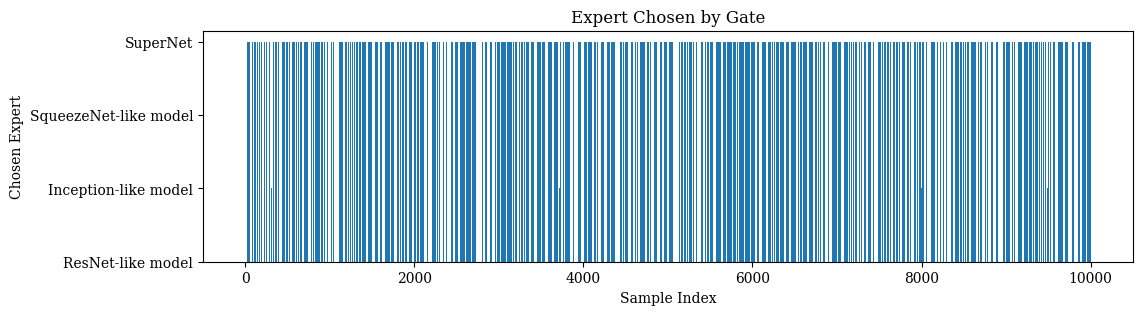

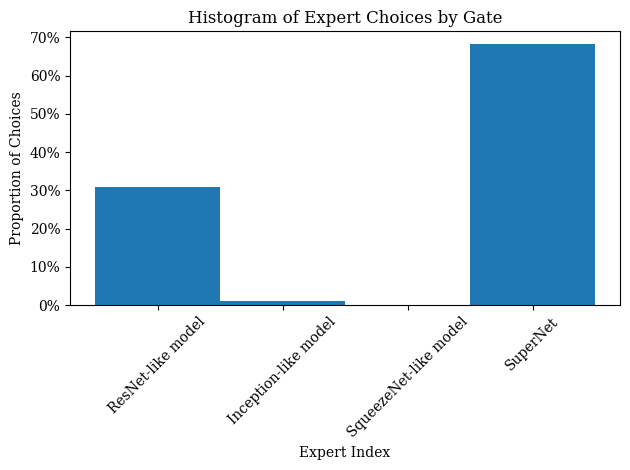

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "text.usetex": False,          # crucial
    "font.family": "serif",
    "mathtext.fontset": "cm",      # Computer Modern for math
    "font.serif": ["DejaVu Serif"] # will be used for normal text
})

# Collect gate outputs for all test images
all_gate_outputs = []
all_labels = []
gate.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        gate_outputs = gate(images).cpu().numpy()
        all_gate_outputs.append(gate_outputs)
        all_labels.append(labels.cpu().numpy())

all_gate_outputs = np.concatenate(all_gate_outputs, axis=0)
chosen_experts = np.argmax(all_gate_outputs, axis=1)

plt.figure(figsize=(12,3))
plt.bar(range(len(chosen_experts)), chosen_experts)
plt.xlabel('Sample Index')
plt.ylabel('Chosen Expert')
plt.title('Expert Chosen by Gate')
plt.yticks(range(len(experts)), [name.replace('_', ' ') for name in expert_names])
plt.savefig('gate_expert_choices.png', dpi=300)
plt.show()


# make a histogram of expert choices
#plt.figure(figsize=(8,5))
plt.hist(chosen_experts, bins=np.arange(len(experts)+1)-0.5, density=True)
plt.xlabel('Expert Index')
plt.ylabel('Proportion of Choices')
plt.title('Histogram of Expert Choices by Gate')
# turn the y-ticks into percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y*100)))
# turn the names  some degrees
plt.xticks(range(len(experts)), [name.replace('_', ' ') for name in expert_names], rotation=45)
plt.tight_layout()
plt.savefig('gate_expert_choice_histogram.png', dpi=300)
plt.show()

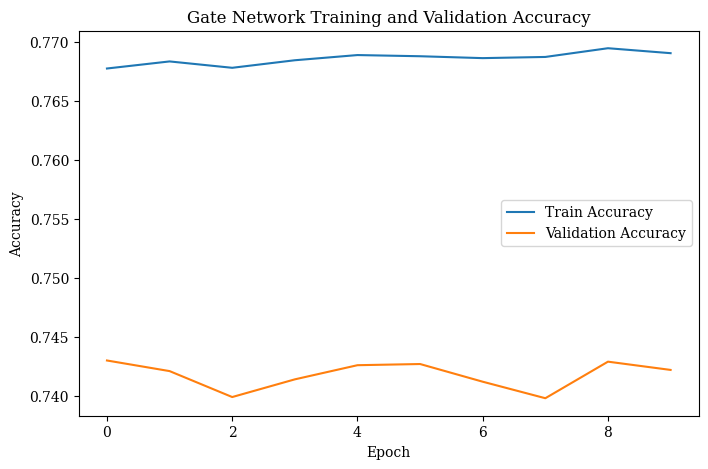

In [28]:
# Plot training and validation accuracy curves for gate network

plt.figure(figsize=(8,5))
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Gate Network Training and Validation Accuracy')
plt.legend()
plt.savefig('gate_training_validation_accuracy.png', dpi=300)
plt.show()